# Lab 10: Keyword Recognition

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity as cs
from librosa.feature import mfcc
import librosa
import os
from scipy.io.wavfile import read
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

## Part 1: Making a Digit Recognizer

In this section we will design a simple spoken digit recognizer, based on Dynamic Time Warping (DTW). In order to make such a system we need to first collect some data, and then design a DTW routine that can compare new inputs with templates for each digit.

To start with make a set of data that will be used here. Make a dozen or so recordings of yourself speaking each of the ten digits (0 to 9). We will use one recording from each digit as the template, and the rest at testing data. In order to not spend too much time collecting the data, record all these utterances in a single (long) sound file. Use your voice activity detector to split that file into the individual spoken digits.

In order to design a digit recognizer we will take a spoken input of a digit and compare it to each digit’s template. By finding which template is the most similar we can classify the input as belonging to that template’s digit. In order to measure the distance between the two sequences we have to use DTW on an appropriate feature space.

Decide which feature to use to represent your speech signals. It can be any feature that we used in the past (e.g. some type of an STFT, MFCCs, etc). When comparing a template with a new input you need to perform the following steps:

1. Compute the distance matrix between all the features of each input. This will be a $M$ by $N$ matrix in which the $(i, j)$ element will represent the distance between the $i$-th frame of the template and the $j$-th frame of the input. We will use the cosine distance which is defined as:

$$D(\mathbf{a},\mathbf{b}) = \frac{\sum a_i b_i}{\sqrt{a_i^2}\sqrt{\sum b_i^2}}$$

2. Once you obtain the distance matrix, you need to compute the cost matrix that encodes the cost of passing through a node given a previously optimal path. We will use the local constraint that to reach node $(i, j)$ you can either come from nodes $(i–1, j–1)$, $(i, j–1)$ or $(i–1, j)$.

3. Starting from the first element of the matrix (1,1), and for each element of the cost matrix you will need to perform the following steps. For node $(i, j)$ you need to examine the nodes from which you can reach it – these will be nodes $(i–1, j–1)$, $(i, j–1)$ or $(i–1, j)$ – and see which one has the lowest cost. Therefore, reaching that node from the optimal path will have the cost of the optimal preceding node plus the distance that corresponds to being at node $(i, j)$. Iterate until you calculate the cost of passing through every node. As you do that, for each node keep track of which of the three preceding nodes was the optimal one.

4. Now you can backtrack and find the optimal path. Start from the final point of the cost matrix and find the node from which you arrived there (it will be the same one that had the lowest cost above). Once you get to that node, repeat this process until you reach the beginning indexes of the two sequences. The path that you took in this process will be the optimal path that aligns the two sequences.

5. The distance between the two sequences will be the cost of being at the final node. Use this to perform the digit classification.

In [2]:
# YOUR CODE HERE
# raise NotImplementedError()
def find_OP(D):  
    C = np.ones_like(D) * (np.inf) # cost matrix
    N, M = D.shape
    C[0,0] = D[0,0]
    for i in range(1,N):
        C[i,0] = C[i-1,0]+D[i,0]
    for j in range(1,M):
        C[0,j] = C[0,j-1]+D[0,j]
    for i in range(1,N):
        for j in range(1,M):
            C[i,j] = min(C[i-1,j]+D[i,j], C[i,j-1]+D[i,j], C[i-1,j-1]+D[i,j])
    return C
    
# Code Reference: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
# The code in this cell is slightly modified for the actual implementation

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#              rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_conf_mat(conf_mat, labels, title, size=4):
    fig, ax = plt.subplots(figsize=(size,size))
    true_label = pred_label = labels
    im, cbar = heatmap(conf_mat, true_label, pred_label, ax=ax, cmap="YlGn", cbarlabel="number of samples")
    texts = annotate_heatmap(im)
    fig.tight_layout()
    plt.title(title)
    plt.xlabel('true labels')
    plt.ylabel('predicting labels')
    plt.show()

In [3]:
path = ['./digits/'+str(i)+'/' for i in range(10)]
train_data = []
test_data = [[] for _ in range(10)]
for i, p in enumerate(path):
    rand = np.random.randint(5)
    for j, f in enumerate(os.listdir(p)):
        if j>=5:
            break
        if j==rand:
            train_data.append(p+f)
        else:
            test_data[i].append(p+f)

Recognizer accuracy is 75.0%


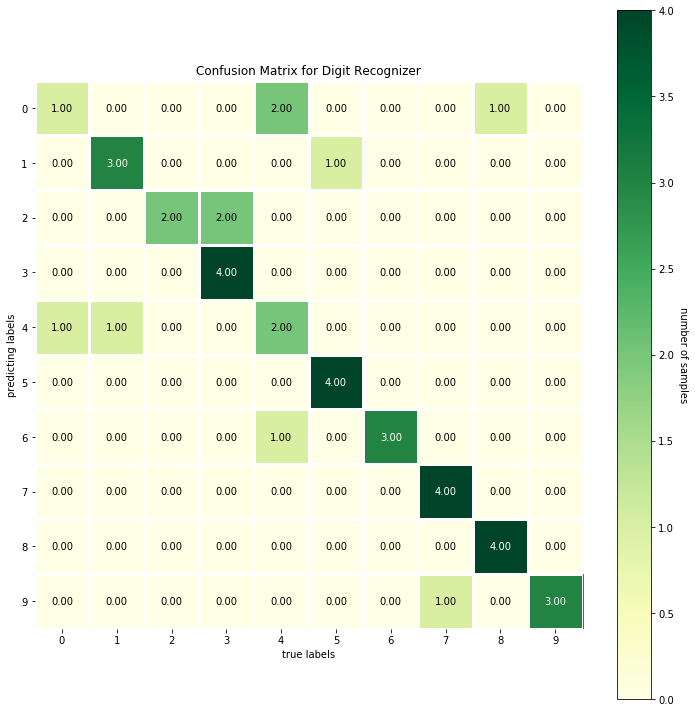

In [4]:
template = []
for d in train_data:
    fs, x = read(d)
    x = x.astype(float)
    x = x/np.max(abs(x))
    nz = np.nonzero(x)[0]
    x = x[nz[0]:nz[-1]+1]
    t = mfcc(y=x, sr=fs, n_mfcc=80)[2:30, :] # template
    t = t.T
    template.append(t)

conf_mat = np.zeros((10, 10))
for i, digit in enumerate(test_data):
    for d in digit:
        fs, x = read(d)
        x = x.astype(float)
        x = x/np.max(abs(x))
        nz = np.nonzero(x)[0]
        x = x[nz[0]:nz[-1]+1]
        f = mfcc(y=x, sr=fs, n_mfcc=80)[2:30, :] # feature
        f = f.T
        cost = [] # cost for each template
        for t in template:
            D = cs(t, f)
            C = find_OP(D)
            cost.append(C[-1, -1])
        pred = np.argmax(cost)
        conf_mat[i, pred] += 1
acc = sum([conf_mat[i,i] for i in range(10)]) / 40
print('Recognizer accuracy is {}%'.format(acc*100))
plot_conf_mat(conf_mat, range(10), 'Confusion Matrix for Digit Recognizer', size=10)

## Part 2. Making a voice-driven dialer

Suppose you just started working for a phone company and the first thing they ask you is to make a hands-free interface for their phones so that people can dial in their friends by voice. During setup, the users speak the name of a contact and then associate it with a number to call. Make a system for which you use the full name of 4-5 of your friends, so that when you speak their name the system recognizes it (and thus could subsequently call their number)

In [5]:
# YOUR CODE HERE
# raise NotImplementedError()
# define functions
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

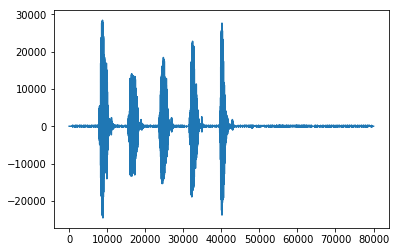

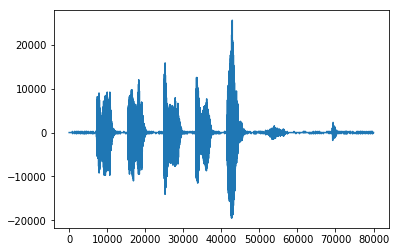

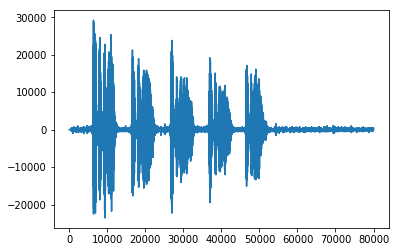

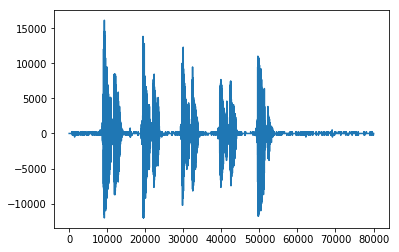

In [6]:
names = ['./names/'+n+'.wav' for n in ['mark', 'allan', 'hasegawa', 'johnson']]
for n in names:
    fs, x = read(n)
    plt.figure()
    plt.plot(x)

In [9]:
# now we hardcode to find voiced regions since I can't find a good vad package for my terrible recordings...
data = []
for n in names:
    fs, x = read(n)
    data.append(x)
mark = [data[0][8000:12000],data[0][15000:19000],data[0][23000:27000],data[0][31000:35000],data[0][38000:42000]]
allan = [data[1][6000:13000],data[1][14000:21000],data[1][23000:30000],data[1][32000:39000],data[1][41000:48000]]
hasegawa = [data[2][5000:12000],data[2][15000:22000],data[2][25000:32000],data[2][35000:42000],data[2][45000:52000]]
johnson = [data[3][8000:14000],data[3][18000:24000],data[3][28000:34000],data[3][38000:44000],data[3][48000:54000]]

train_data = []
test_data = [[] for j in range(4)]
for i, n in enumerate([mark, allan, hasegawa, johnson]):
    rand = np.random.randint(4)
    for j, d in enumerate(n):
        if j==rand:
            train_data.append(d)
        else:
            test_data[i].append(d)     

Recognizer accuracy is 87.5%


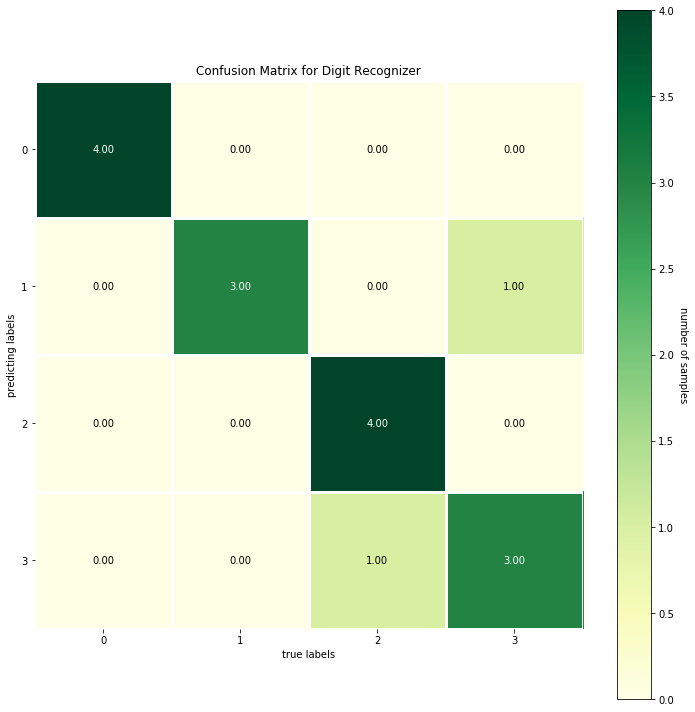

In [10]:
template = []
for d in train_data:
    x = d/np.max(abs(d))
    t = mfcc(y=x, sr=8000, n_mfcc=80)[2:30, :] # template
    t = t.T
    template.append(t)

conf_mat = np.zeros((4, 4))
for i, n in enumerate(test_data):
    for d in n:
        x = d/np.max(abs(d))
        f = mfcc(y=x, sr=8000, n_mfcc=80)[2:30, :] # feature
        f = f.T
        cost = [] # cost for each template
        for t in template:
            D = cs(t, f)
            C = find_OP(D)
            cost.append(C[-1, -1])
        pred = np.argmax(cost)
        conf_mat[i, pred] += 1
acc = sum([conf_mat[i,i] for i in range(4)]) / 16
print('Recognizer accuracy is {}%'.format(acc*100))
plot_conf_mat(conf_mat, range(4), 'Confusion Matrix for Digit Recognizer', size=10)